# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

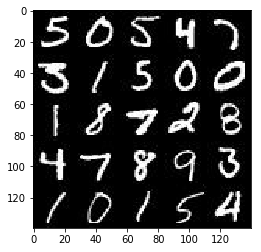

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

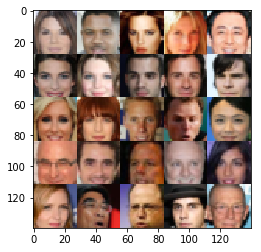

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # COMPLETED: Implement Function
    # Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
    real_input_images = tf.placeholder(tf.float32, 
                                       shape=(None, image_width, image_height, image_channels), name='real_input_images')
    # Z input placeholder with rank 2 using z_dim.
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    # Learning rate placeholder with rank 0.
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    # print('real_input_images: {}'.format(real_input_images))
    # print('z_input: {}'.format(z_input))
    # print('learning_rate: {}'.format(learning_rate))
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.8, size_mult=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # COMPLETED: Implement Function
    # https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layers x1, x2, x3
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=size_mult, 
                              kernel_size=5, 
                              strides=2, 
                              padding='same')
        relu1 = tf.maximum(x=(alpha * x1), y=x1)
        # print('relu1: {}'.format(relu1))
        
        x2 = tf.layers.conv2d(inputs=relu1, 
                              filters=(size_mult * 2), 
                              kernel_size=5, 
                              strides=2, 
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(x=(alpha * x2), y=x2)
        # print('relu2: {}'.format(relu2))
        
        x3 = tf.layers.conv2d(inputs=relu2, 
                              filters=(size_mult * 4), 
                              kernel_size=5, 
                              strides=2, 
                              padding='same')
        bn3 = tf.layers.batch_normalization(inputs=x3, training=True)
        relu3 = tf.maximum(x=(alpha * bn3), y=bn3)
        # print('relu3: {}'.format(relu3))
        
        # Flatten
        # https://www.tensorflow.org/api_docs/python/tf/reshape
        flat = tf.reshape(tensor=relu3, shape=(-1, 4 * 4 * 256))
        
        # Dropout
        # https://www.tensorflow.org/api_docs/python/tf/layers/dropout
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        
        # Output layers
        # https://www.tensorflow.org/api_docs/python/tf/layers/dense
        logits_of_discriminator = tf.layers.dense(inputs=dropout_layer, units=1)
        output_of_discriminator = tf.sigmoid(logits_of_discriminator)
        # print('logits_of_discriminator: {}'.format(logits_of_discriminator))
        # print('output_of_discriminator: {}'.format(output_of_discriminator))
        
    return output_of_discriminator, logits_of_discriminator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, size_mult=64):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # COMPLETED: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # Layers x1, x2, x3
        x1 = tf.layers.dense(inputs=z, units=(7 * 7 * 256))  # units=(3 * 3 * 512), units=(4 * 4 * 512)
        x1 = tf.reshape(tensor=x1, shape=(-1, 7, 7, 256))  # shape=(-1, 3, 3, 512), shape=(-1, 4, 4, 512)
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_train)
        x1 = tf.maximum(x=(alpha * x1), y=x1)
        
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=(size_mult * 2), 
                                        kernel_size=4, 
                                        strides=1, 
                                        padding='same')
        
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(x=(alpha * x2), y=x2)
        
        x3 = tf.layers.conv2d_transpose(inputs=x2, 
                                        filters=size_mult, 
                                        kernel_size=4, 
                                        strides=2, 
                                        padding='same')
        
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(x=(alpha * x3), y=x3)
        
        # Output layers
        logits_of_generator = tf.layers.conv2d_transpose(inputs=x3, 
                                                         filters=out_channel_dim, 
                                                         kernel_size=5,
                                                         strides=2, 
                                                         padding='same')
        
        output_of_generator = tf.tanh(logits_of_generator)
        # print('logits_of_generator: {}'.format(logits_of_generator))
        # print('output_of_generator: {}'.format(output_of_generator))
        
        return output_of_generator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # COMPLETED: Implement Function
    # Add smoothing tip from slack channel 
    smooth = np.random.uniform(0.0, 0.3)
    generator_model = generator(input_z, out_channel_dim)
    
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean( \
        input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, \
        labels=tf.ones_like(discriminator_logits_real) * smooth))
    
    discriminator_loss_fake = tf.reduce_mean( \
        input_tensor=tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, \
        labels=tf.zeros_like(discriminator_logits_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    
    gen_loss = tf.reduce_mean( \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, \
        labels=tf.ones_like(discriminator_logits_fake)))
    
    # print('discriminator_loss: {}'.format(discriminator_loss))
    # print('gen_loss: {}'.format(gen_loss))
    return discriminator_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # COMPLETED: Implement Function
    t_vars = tf.trainable_variables()  # scope=None
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # https://www.tensorflow.org/api_docs/python/tf/control_dependencies
    # https://www.tensorflow.org/api_docs/python/tf/GraphKeys
    with tf.control_dependencies(control_inputs=tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    # print('d_train_opt: {}'.format(d_train_opt))
    # print('g_train_opt: {}'.format(g_train_opt))
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # COMPLETED: Build Model
    # Setup
    steps = 0
    images_viewed = 0

    # Model inputs, losses, and optimizers
    input_real, input_z, lr = model_inputs(*data_shape[1:4], z_dim)
    # Model losses
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # Model optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # COMPLETED: Train Model
                steps += 1
                batch_images *= 2
                images_viewed += len(batch_images)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                if steps % 10 == 0:
                    # Collect losses and print out 10 batches/steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch: {}/{} ".format(epoch_i + 1, epoch_count),
                          "Steps: {:>4,} ".format(steps),
                          "Images viewed: {:>6,}".format(images_viewed),
                          "Discriminator Loss: {:.4f} ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # It's recommended to print the generator output every 100 batches.
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2  Steps:   10  Images viewed:    640 Discriminator Loss: 0.6201  Generator Loss: 2.5642
Epoch: 1/2  Steps:   20  Images viewed:  1,280 Discriminator Loss: 0.5886  Generator Loss: 2.9166
Epoch: 1/2  Steps:   30  Images viewed:  1,920 Discriminator Loss: 0.6254  Generator Loss: 3.1157
Epoch: 1/2  Steps:   40  Images viewed:  2,560 Discriminator Loss: 0.6472  Generator Loss: 2.7562
Epoch: 1/2  Steps:   50  Images viewed:  3,200 Discriminator Loss: 0.8518  Generator Loss: 3.8354
Epoch: 1/2  Steps:   60  Images viewed:  3,840 Discriminator Loss: 0.6310  Generator Loss: 2.5303
Epoch: 1/2  Steps:   70  Images viewed:  4,480 Discriminator Loss: 0.6322  Generator Loss: 2.6063
Epoch: 1/2  Steps:   80  Images viewed:  5,120 Discriminator Loss: 0.5679  Generator Loss: 3.7379
Epoch: 1/2  Steps:   90  Images viewed:  5,760 Discriminator Loss: 0.5631  Generator Loss: 3.6062
Epoch: 1/2  Steps:  100  Images viewed:  6,400 Discriminator Loss: 0.6140  Generator Loss: 3.9224


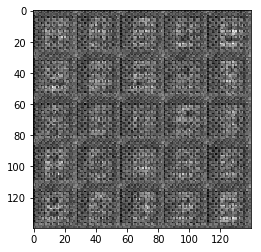

Epoch: 1/2  Steps:  110  Images viewed:  7,040 Discriminator Loss: 0.6263  Generator Loss: 2.9105
Epoch: 1/2  Steps:  120  Images viewed:  7,680 Discriminator Loss: 0.5763  Generator Loss: 3.4791
Epoch: 1/2  Steps:  130  Images viewed:  8,320 Discriminator Loss: 0.5764  Generator Loss: 3.3400
Epoch: 1/2  Steps:  140  Images viewed:  8,960 Discriminator Loss: 0.6489  Generator Loss: 2.4668
Epoch: 1/2  Steps:  150  Images viewed:  9,600 Discriminator Loss: 0.5852  Generator Loss: 3.0948
Epoch: 1/2  Steps:  160  Images viewed: 10,240 Discriminator Loss: 0.5890  Generator Loss: 3.2562
Epoch: 1/2  Steps:  170  Images viewed: 10,880 Discriminator Loss: 0.6212  Generator Loss: 2.5632
Epoch: 1/2  Steps:  180  Images viewed: 11,520 Discriminator Loss: 0.6013  Generator Loss: 3.0164
Epoch: 1/2  Steps:  190  Images viewed: 12,160 Discriminator Loss: 0.6170  Generator Loss: 3.6059
Epoch: 1/2  Steps:  200  Images viewed: 12,800 Discriminator Loss: 0.6082  Generator Loss: 2.7260


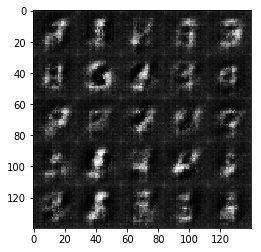

Epoch: 1/2  Steps:  210  Images viewed: 13,440 Discriminator Loss: 0.6557  Generator Loss: 2.2707
Epoch: 1/2  Steps:  220  Images viewed: 14,080 Discriminator Loss: 0.5938  Generator Loss: 2.9806
Epoch: 1/2  Steps:  230  Images viewed: 14,720 Discriminator Loss: 0.5961  Generator Loss: 3.0128
Epoch: 1/2  Steps:  240  Images viewed: 15,360 Discriminator Loss: 0.6255  Generator Loss: 3.4764
Epoch: 1/2  Steps:  250  Images viewed: 16,000 Discriminator Loss: 0.6344  Generator Loss: 2.3621
Epoch: 1/2  Steps:  260  Images viewed: 16,640 Discriminator Loss: 0.6808  Generator Loss: 3.6833
Epoch: 1/2  Steps:  270  Images viewed: 17,280 Discriminator Loss: 0.6048  Generator Loss: 2.8069
Epoch: 1/2  Steps:  280  Images viewed: 17,920 Discriminator Loss: 0.6260  Generator Loss: 2.5127
Epoch: 1/2  Steps:  290  Images viewed: 18,560 Discriminator Loss: 0.6591  Generator Loss: 2.2148
Epoch: 1/2  Steps:  300  Images viewed: 19,200 Discriminator Loss: 0.6150  Generator Loss: 2.5638


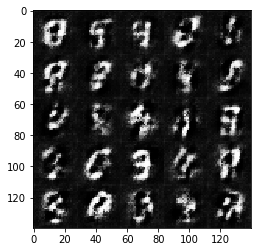

Epoch: 1/2  Steps:  310  Images viewed: 19,840 Discriminator Loss: 0.6049  Generator Loss: 2.8038
Epoch: 1/2  Steps:  320  Images viewed: 20,480 Discriminator Loss: 0.6253  Generator Loss: 2.6485
Epoch: 1/2  Steps:  330  Images viewed: 21,120 Discriminator Loss: 0.6191  Generator Loss: 2.8340
Epoch: 1/2  Steps:  340  Images viewed: 21,760 Discriminator Loss: 0.6136  Generator Loss: 2.7527
Epoch: 1/2  Steps:  350  Images viewed: 22,400 Discriminator Loss: 0.6178  Generator Loss: 2.6207
Epoch: 1/2  Steps:  360  Images viewed: 23,040 Discriminator Loss: 0.6026  Generator Loss: 2.7707
Epoch: 1/2  Steps:  370  Images viewed: 23,680 Discriminator Loss: 0.6334  Generator Loss: 2.3964
Epoch: 1/2  Steps:  380  Images viewed: 24,320 Discriminator Loss: 0.6144  Generator Loss: 2.7900
Epoch: 1/2  Steps:  390  Images viewed: 24,960 Discriminator Loss: 0.6253  Generator Loss: 2.7911
Epoch: 1/2  Steps:  400  Images viewed: 25,600 Discriminator Loss: 0.6154  Generator Loss: 2.9147


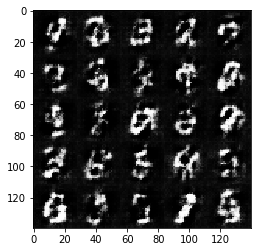

Epoch: 1/2  Steps:  410  Images viewed: 26,240 Discriminator Loss: 0.6204  Generator Loss: 2.5949
Epoch: 1/2  Steps:  420  Images viewed: 26,880 Discriminator Loss: 0.6337  Generator Loss: 2.5119
Epoch: 1/2  Steps:  430  Images viewed: 27,520 Discriminator Loss: 0.6182  Generator Loss: 2.5686
Epoch: 1/2  Steps:  440  Images viewed: 28,160 Discriminator Loss: 0.6276  Generator Loss: 2.8306
Epoch: 1/2  Steps:  450  Images viewed: 28,800 Discriminator Loss: 0.6268  Generator Loss: 3.0145
Epoch: 1/2  Steps:  460  Images viewed: 29,440 Discriminator Loss: 0.6215  Generator Loss: 2.5796
Epoch: 1/2  Steps:  470  Images viewed: 30,080 Discriminator Loss: 0.6331  Generator Loss: 3.1062
Epoch: 1/2  Steps:  480  Images viewed: 30,720 Discriminator Loss: 0.6249  Generator Loss: 2.9207
Epoch: 1/2  Steps:  490  Images viewed: 31,360 Discriminator Loss: 0.6295  Generator Loss: 2.4460
Epoch: 1/2  Steps:  500  Images viewed: 32,000 Discriminator Loss: 0.6467  Generator Loss: 2.3095


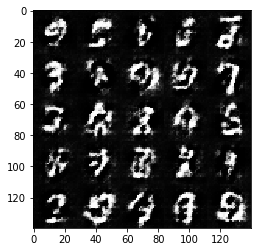

Epoch: 1/2  Steps:  510  Images viewed: 32,640 Discriminator Loss: 0.6276  Generator Loss: 3.1407
Epoch: 1/2  Steps:  520  Images viewed: 33,280 Discriminator Loss: 0.6660  Generator Loss: 2.1401
Epoch: 1/2  Steps:  530  Images viewed: 33,920 Discriminator Loss: 0.6218  Generator Loss: 2.5611
Epoch: 1/2  Steps:  540  Images viewed: 34,560 Discriminator Loss: 0.6139  Generator Loss: 2.7379
Epoch: 1/2  Steps:  550  Images viewed: 35,200 Discriminator Loss: 0.7204  Generator Loss: 3.7892
Epoch: 1/2  Steps:  560  Images viewed: 35,840 Discriminator Loss: 0.6435  Generator Loss: 3.1360
Epoch: 1/2  Steps:  570  Images viewed: 36,480 Discriminator Loss: 0.6220  Generator Loss: 2.5931
Epoch: 1/2  Steps:  580  Images viewed: 37,120 Discriminator Loss: 0.6261  Generator Loss: 3.1808
Epoch: 1/2  Steps:  590  Images viewed: 37,760 Discriminator Loss: 0.6173  Generator Loss: 2.7611
Epoch: 1/2  Steps:  600  Images viewed: 38,400 Discriminator Loss: 0.6154  Generator Loss: 2.6949


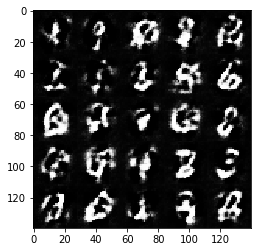

Epoch: 1/2  Steps:  610  Images viewed: 39,040 Discriminator Loss: 0.6120  Generator Loss: 2.7187
Epoch: 1/2  Steps:  620  Images viewed: 39,680 Discriminator Loss: 0.6745  Generator Loss: 3.5087
Epoch: 1/2  Steps:  630  Images viewed: 40,320 Discriminator Loss: 0.6089  Generator Loss: 2.9028
Epoch: 1/2  Steps:  640  Images viewed: 40,960 Discriminator Loss: 0.6301  Generator Loss: 2.4682
Epoch: 1/2  Steps:  650  Images viewed: 41,600 Discriminator Loss: 0.6168  Generator Loss: 2.6040
Epoch: 1/2  Steps:  660  Images viewed: 42,240 Discriminator Loss: 0.6184  Generator Loss: 2.9797
Epoch: 1/2  Steps:  670  Images viewed: 42,880 Discriminator Loss: 0.6161  Generator Loss: 2.9461
Epoch: 1/2  Steps:  680  Images viewed: 43,520 Discriminator Loss: 0.6332  Generator Loss: 3.0174
Epoch: 1/2  Steps:  690  Images viewed: 44,160 Discriminator Loss: 0.6134  Generator Loss: 2.9752
Epoch: 1/2  Steps:  700  Images viewed: 44,800 Discriminator Loss: 0.6223  Generator Loss: 2.5175


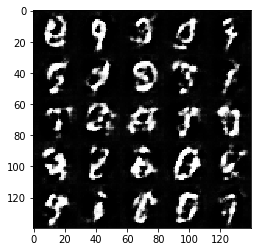

Epoch: 1/2  Steps:  710  Images viewed: 45,440 Discriminator Loss: 0.6038  Generator Loss: 2.8806
Epoch: 1/2  Steps:  720  Images viewed: 46,080 Discriminator Loss: 0.6214  Generator Loss: 3.2781
Epoch: 1/2  Steps:  730  Images viewed: 46,720 Discriminator Loss: 0.6144  Generator Loss: 2.7483
Epoch: 1/2  Steps:  740  Images viewed: 47,360 Discriminator Loss: 0.6445  Generator Loss: 2.4481
Epoch: 1/2  Steps:  750  Images viewed: 48,000 Discriminator Loss: 0.6064  Generator Loss: 2.8747
Epoch: 1/2  Steps:  760  Images viewed: 48,640 Discriminator Loss: 0.6174  Generator Loss: 2.7158
Epoch: 1/2  Steps:  770  Images viewed: 49,280 Discriminator Loss: 0.6268  Generator Loss: 2.4787
Epoch: 1/2  Steps:  780  Images viewed: 49,920 Discriminator Loss: 0.6318  Generator Loss: 2.4623
Epoch: 1/2  Steps:  790  Images viewed: 50,560 Discriminator Loss: 0.6687  Generator Loss: 3.8421
Epoch: 1/2  Steps:  800  Images viewed: 51,200 Discriminator Loss: 0.6420  Generator Loss: 3.2205


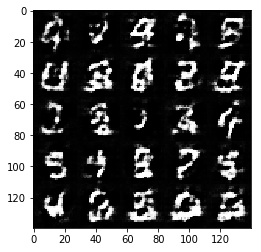

Epoch: 1/2  Steps:  810  Images viewed: 51,840 Discriminator Loss: 0.6201  Generator Loss: 2.6620
Epoch: 1/2  Steps:  820  Images viewed: 52,480 Discriminator Loss: 0.6428  Generator Loss: 2.5047
Epoch: 1/2  Steps:  830  Images viewed: 53,120 Discriminator Loss: 0.6264  Generator Loss: 2.5975
Epoch: 1/2  Steps:  840  Images viewed: 53,760 Discriminator Loss: 0.6266  Generator Loss: 2.8925
Epoch: 1/2  Steps:  850  Images viewed: 54,400 Discriminator Loss: 0.6351  Generator Loss: 2.4539
Epoch: 1/2  Steps:  860  Images viewed: 55,040 Discriminator Loss: 0.6229  Generator Loss: 2.8379
Epoch: 1/2  Steps:  870  Images viewed: 55,680 Discriminator Loss: 0.6228  Generator Loss: 2.5126
Epoch: 1/2  Steps:  880  Images viewed: 56,320 Discriminator Loss: 0.6347  Generator Loss: 3.0146
Epoch: 1/2  Steps:  890  Images viewed: 56,960 Discriminator Loss: 0.6378  Generator Loss: 2.4496
Epoch: 1/2  Steps:  900  Images viewed: 57,600 Discriminator Loss: 0.6306  Generator Loss: 3.2192


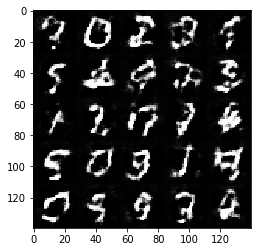

Epoch: 1/2  Steps:  910  Images viewed: 58,240 Discriminator Loss: 0.6132  Generator Loss: 2.8509
Epoch: 1/2  Steps:  920  Images viewed: 58,880 Discriminator Loss: 0.6122  Generator Loss: 2.8147
Epoch: 1/2  Steps:  930  Images viewed: 59,520 Discriminator Loss: 0.6451  Generator Loss: 2.3273
Epoch: 2/2  Steps:  940  Images viewed: 60,160 Discriminator Loss: 0.6416  Generator Loss: 2.8352
Epoch: 2/2  Steps:  950  Images viewed: 60,800 Discriminator Loss: 0.6335  Generator Loss: 2.4337
Epoch: 2/2  Steps:  960  Images viewed: 61,440 Discriminator Loss: 0.6493  Generator Loss: 3.0903
Epoch: 2/2  Steps:  970  Images viewed: 62,080 Discriminator Loss: 0.6588  Generator Loss: 2.2263
Epoch: 2/2  Steps:  980  Images viewed: 62,720 Discriminator Loss: 0.6367  Generator Loss: 3.2682
Epoch: 2/2  Steps:  990  Images viewed: 63,360 Discriminator Loss: 0.6233  Generator Loss: 2.5703
Epoch: 2/2  Steps: 1,000  Images viewed: 64,000 Discriminator Loss: 0.6469  Generator Loss: 2.3492


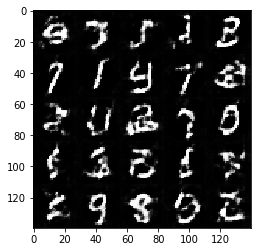

Epoch: 2/2  Steps: 1,010  Images viewed: 64,640 Discriminator Loss: 0.6268  Generator Loss: 2.5731
Epoch: 2/2  Steps: 1,020  Images viewed: 65,280 Discriminator Loss: 0.6314  Generator Loss: 3.0290
Epoch: 2/2  Steps: 1,030  Images viewed: 65,920 Discriminator Loss: 0.6273  Generator Loss: 2.5471
Epoch: 2/2  Steps: 1,040  Images viewed: 66,560 Discriminator Loss: 0.6427  Generator Loss: 2.7315
Epoch: 2/2  Steps: 1,050  Images viewed: 67,200 Discriminator Loss: 0.6385  Generator Loss: 2.3869
Epoch: 2/2  Steps: 1,060  Images viewed: 67,840 Discriminator Loss: 0.6660  Generator Loss: 2.2425
Epoch: 2/2  Steps: 1,070  Images viewed: 68,480 Discriminator Loss: 0.6409  Generator Loss: 2.3628
Epoch: 2/2  Steps: 1,080  Images viewed: 69,120 Discriminator Loss: 0.6308  Generator Loss: 3.1093
Epoch: 2/2  Steps: 1,090  Images viewed: 69,760 Discriminator Loss: 0.6270  Generator Loss: 2.6606
Epoch: 2/2  Steps: 1,100  Images viewed: 70,400 Discriminator Loss: 0.6275  Generator Loss: 3.1125


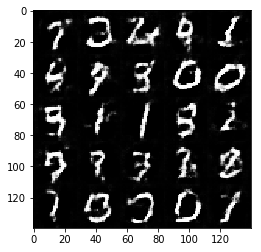

Epoch: 2/2  Steps: 1,110  Images viewed: 71,040 Discriminator Loss: 0.6508  Generator Loss: 3.1451
Epoch: 2/2  Steps: 1,120  Images viewed: 71,680 Discriminator Loss: 0.6348  Generator Loss: 2.9895
Epoch: 2/2  Steps: 1,130  Images viewed: 72,320 Discriminator Loss: 0.6436  Generator Loss: 2.9303
Epoch: 2/2  Steps: 1,140  Images viewed: 72,960 Discriminator Loss: 0.6353  Generator Loss: 2.9410
Epoch: 2/2  Steps: 1,150  Images viewed: 73,600 Discriminator Loss: 0.6220  Generator Loss: 2.6315
Epoch: 2/2  Steps: 1,160  Images viewed: 74,240 Discriminator Loss: 0.6451  Generator Loss: 2.3900
Epoch: 2/2  Steps: 1,170  Images viewed: 74,880 Discriminator Loss: 0.6170  Generator Loss: 2.7032
Epoch: 2/2  Steps: 1,180  Images viewed: 75,520 Discriminator Loss: 0.6333  Generator Loss: 2.9305
Epoch: 2/2  Steps: 1,190  Images viewed: 76,160 Discriminator Loss: 0.6521  Generator Loss: 2.9289
Epoch: 2/2  Steps: 1,200  Images viewed: 76,800 Discriminator Loss: 0.6231  Generator Loss: 2.6481


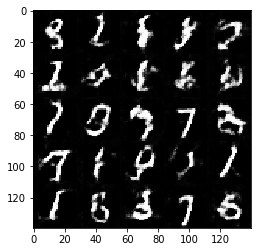

Epoch: 2/2  Steps: 1,210  Images viewed: 77,440 Discriminator Loss: 0.6351  Generator Loss: 2.9056
Epoch: 2/2  Steps: 1,220  Images viewed: 78,080 Discriminator Loss: 0.6447  Generator Loss: 3.2338
Epoch: 2/2  Steps: 1,230  Images viewed: 78,720 Discriminator Loss: 0.6238  Generator Loss: 2.5694
Epoch: 2/2  Steps: 1,240  Images viewed: 79,360 Discriminator Loss: 0.6346  Generator Loss: 2.5429
Epoch: 2/2  Steps: 1,250  Images viewed: 80,000 Discriminator Loss: 0.6685  Generator Loss: 2.1304
Epoch: 2/2  Steps: 1,260  Images viewed: 80,640 Discriminator Loss: 0.6524  Generator Loss: 3.2180
Epoch: 2/2  Steps: 1,270  Images viewed: 81,280 Discriminator Loss: 0.6617  Generator Loss: 2.2163
Epoch: 2/2  Steps: 1,280  Images viewed: 81,920 Discriminator Loss: 0.6390  Generator Loss: 2.7801
Epoch: 2/2  Steps: 1,290  Images viewed: 82,560 Discriminator Loss: 0.6366  Generator Loss: 2.7697
Epoch: 2/2  Steps: 1,300  Images viewed: 83,200 Discriminator Loss: 0.6520  Generator Loss: 2.3789


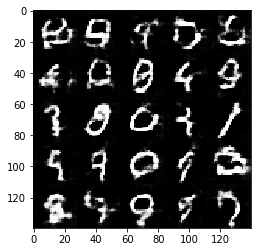

Epoch: 2/2  Steps: 1,310  Images viewed: 83,840 Discriminator Loss: 0.6387  Generator Loss: 2.5167
Epoch: 2/2  Steps: 1,320  Images viewed: 84,480 Discriminator Loss: 0.6330  Generator Loss: 2.7047
Epoch: 2/2  Steps: 1,330  Images viewed: 85,120 Discriminator Loss: 0.6345  Generator Loss: 2.5524
Epoch: 2/2  Steps: 1,340  Images viewed: 85,760 Discriminator Loss: 0.6341  Generator Loss: 2.5964
Epoch: 2/2  Steps: 1,350  Images viewed: 86,400 Discriminator Loss: 0.6395  Generator Loss: 2.5453
Epoch: 2/2  Steps: 1,360  Images viewed: 87,040 Discriminator Loss: 0.6394  Generator Loss: 2.9661
Epoch: 2/2  Steps: 1,370  Images viewed: 87,680 Discriminator Loss: 0.6330  Generator Loss: 2.6776
Epoch: 2/2  Steps: 1,380  Images viewed: 88,320 Discriminator Loss: 0.6578  Generator Loss: 2.2730
Epoch: 2/2  Steps: 1,390  Images viewed: 88,960 Discriminator Loss: 0.6312  Generator Loss: 3.0150
Epoch: 2/2  Steps: 1,400  Images viewed: 89,600 Discriminator Loss: 0.6471  Generator Loss: 2.3859


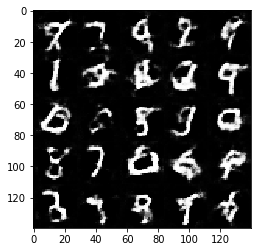

Epoch: 2/2  Steps: 1,410  Images viewed: 90,240 Discriminator Loss: 0.6383  Generator Loss: 2.4954
Epoch: 2/2  Steps: 1,420  Images viewed: 90,880 Discriminator Loss: 0.6521  Generator Loss: 2.5977
Epoch: 2/2  Steps: 1,430  Images viewed: 91,520 Discriminator Loss: 0.6421  Generator Loss: 2.4196
Epoch: 2/2  Steps: 1,440  Images viewed: 92,160 Discriminator Loss: 0.6684  Generator Loss: 2.1932
Epoch: 2/2  Steps: 1,450  Images viewed: 92,800 Discriminator Loss: 0.6351  Generator Loss: 2.5242
Epoch: 2/2  Steps: 1,460  Images viewed: 93,440 Discriminator Loss: 0.6279  Generator Loss: 2.7173
Epoch: 2/2  Steps: 1,470  Images viewed: 94,080 Discriminator Loss: 0.6357  Generator Loss: 2.7381
Epoch: 2/2  Steps: 1,480  Images viewed: 94,720 Discriminator Loss: 0.6360  Generator Loss: 2.6914
Epoch: 2/2  Steps: 1,490  Images viewed: 95,360 Discriminator Loss: 0.6384  Generator Loss: 2.4840
Epoch: 2/2  Steps: 1,500  Images viewed: 96,000 Discriminator Loss: 0.6629  Generator Loss: 3.0974


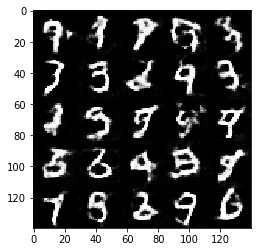

Epoch: 2/2  Steps: 1,510  Images viewed: 96,640 Discriminator Loss: 0.6719  Generator Loss: 3.2958
Epoch: 2/2  Steps: 1,520  Images viewed: 97,280 Discriminator Loss: 0.6465  Generator Loss: 2.4027
Epoch: 2/2  Steps: 1,530  Images viewed: 97,920 Discriminator Loss: 0.6340  Generator Loss: 2.4708
Epoch: 2/2  Steps: 1,540  Images viewed: 98,560 Discriminator Loss: 0.6311  Generator Loss: 2.4924
Epoch: 2/2  Steps: 1,550  Images viewed: 99,200 Discriminator Loss: 0.6417  Generator Loss: 2.3826
Epoch: 2/2  Steps: 1,560  Images viewed: 99,840 Discriminator Loss: 0.6388  Generator Loss: 2.4526
Epoch: 2/2  Steps: 1,570  Images viewed: 100,480 Discriminator Loss: 0.6442  Generator Loss: 2.3860
Epoch: 2/2  Steps: 1,580  Images viewed: 101,120 Discriminator Loss: 0.6403  Generator Loss: 2.4640
Epoch: 2/2  Steps: 1,590  Images viewed: 101,760 Discriminator Loss: 0.6939  Generator Loss: 3.3790
Epoch: 2/2  Steps: 1,600  Images viewed: 102,400 Discriminator Loss: 0.6340  Generator Loss: 2.8988


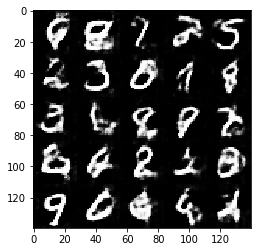

Epoch: 2/2  Steps: 1,610  Images viewed: 103,040 Discriminator Loss: 0.6349  Generator Loss: 2.6126
Epoch: 2/2  Steps: 1,620  Images viewed: 103,680 Discriminator Loss: 0.6360  Generator Loss: 2.5078
Epoch: 2/2  Steps: 1,630  Images viewed: 104,320 Discriminator Loss: 0.6462  Generator Loss: 2.6741
Epoch: 2/2  Steps: 1,640  Images viewed: 104,960 Discriminator Loss: 0.6328  Generator Loss: 2.6052
Epoch: 2/2  Steps: 1,650  Images viewed: 105,600 Discriminator Loss: 0.6324  Generator Loss: 2.5574
Epoch: 2/2  Steps: 1,660  Images viewed: 106,240 Discriminator Loss: 0.6328  Generator Loss: 2.5937
Epoch: 2/2  Steps: 1,670  Images viewed: 106,880 Discriminator Loss: 0.6397  Generator Loss: 2.6780
Epoch: 2/2  Steps: 1,680  Images viewed: 107,520 Discriminator Loss: 0.6636  Generator Loss: 3.2219
Epoch: 2/2  Steps: 1,690  Images viewed: 108,160 Discriminator Loss: 0.6306  Generator Loss: 2.5843
Epoch: 2/2  Steps: 1,700  Images viewed: 108,800 Discriminator Loss: 0.6304  Generator Loss: 3.0177


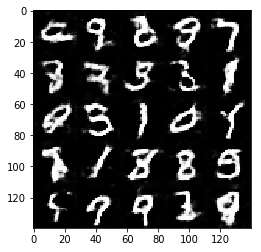

Epoch: 2/2  Steps: 1,710  Images viewed: 109,440 Discriminator Loss: 0.6409  Generator Loss: 2.5505
Epoch: 2/2  Steps: 1,720  Images viewed: 110,080 Discriminator Loss: 0.6422  Generator Loss: 2.4130
Epoch: 2/2  Steps: 1,730  Images viewed: 110,720 Discriminator Loss: 0.6558  Generator Loss: 2.2597
Epoch: 2/2  Steps: 1,740  Images viewed: 111,360 Discriminator Loss: 0.6385  Generator Loss: 2.8911
Epoch: 2/2  Steps: 1,750  Images viewed: 112,000 Discriminator Loss: 0.6415  Generator Loss: 3.1008
Epoch: 2/2  Steps: 1,760  Images viewed: 112,640 Discriminator Loss: 0.6242  Generator Loss: 2.6799
Epoch: 2/2  Steps: 1,770  Images viewed: 113,280 Discriminator Loss: 0.6676  Generator Loss: 2.7881
Epoch: 2/2  Steps: 1,780  Images viewed: 113,920 Discriminator Loss: 0.6433  Generator Loss: 2.6979
Epoch: 2/2  Steps: 1,790  Images viewed: 114,560 Discriminator Loss: 0.6385  Generator Loss: 2.5472
Epoch: 2/2  Steps: 1,800  Images viewed: 115,200 Discriminator Loss: 0.6802  Generator Loss: 3.1750


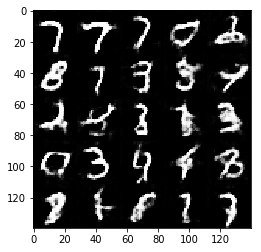

Epoch: 2/2  Steps: 1,810  Images viewed: 115,840 Discriminator Loss: 0.6565  Generator Loss: 2.2503
Epoch: 2/2  Steps: 1,820  Images viewed: 116,480 Discriminator Loss: 0.6352  Generator Loss: 2.5487
Epoch: 2/2  Steps: 1,830  Images viewed: 117,120 Discriminator Loss: 0.6514  Generator Loss: 2.8878
Epoch: 2/2  Steps: 1,840  Images viewed: 117,760 Discriminator Loss: 0.6398  Generator Loss: 2.6854
Epoch: 2/2  Steps: 1,850  Images viewed: 118,400 Discriminator Loss: 0.6525  Generator Loss: 2.5065
Epoch: 2/2  Steps: 1,860  Images viewed: 119,040 Discriminator Loss: 0.6410  Generator Loss: 2.6460
Epoch: 2/2  Steps: 1,870  Images viewed: 119,680 Discriminator Loss: 0.6394  Generator Loss: 2.4359


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001  # 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1  Steps:   10  Images viewed:    640 Discriminator Loss: 0.4933  Generator Loss: 2.7264
Epoch: 1/1  Steps:   20  Images viewed:  1,280 Discriminator Loss: 0.4941  Generator Loss: 2.8163
Epoch: 1/1  Steps:   30  Images viewed:  1,920 Discriminator Loss: 0.4691  Generator Loss: 3.2559
Epoch: 1/1  Steps:   40  Images viewed:  2,560 Discriminator Loss: 0.4518  Generator Loss: 3.9114
Epoch: 1/1  Steps:   50  Images viewed:  3,200 Discriminator Loss: 0.4332  Generator Loss: 4.1396
Epoch: 1/1  Steps:   60  Images viewed:  3,840 Discriminator Loss: 0.4338  Generator Loss: 4.3016
Epoch: 1/1  Steps:   70  Images viewed:  4,480 Discriminator Loss: 0.4298  Generator Loss: 4.1571
Epoch: 1/1  Steps:   80  Images viewed:  5,120 Discriminator Loss: 0.4180  Generator Loss: 4.8741
Epoch: 1/1  Steps:   90  Images viewed:  5,760 Discriminator Loss: 0.4603  Generator Loss: 3.2635
Epoch: 1/1  Steps:  100  Images viewed:  6,400 Discriminator Loss: 0.4378  Generator Loss: 4.4416


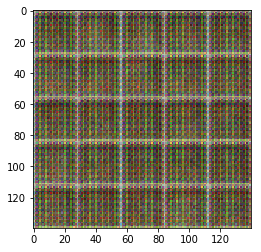

Epoch: 1/1  Steps:  110  Images viewed:  7,040 Discriminator Loss: 0.4323  Generator Loss: 3.8581
Epoch: 1/1  Steps:  120  Images viewed:  7,680 Discriminator Loss: 0.4430  Generator Loss: 3.5789
Epoch: 1/1  Steps:  130  Images viewed:  8,320 Discriminator Loss: 0.4523  Generator Loss: 3.7055
Epoch: 1/1  Steps:  140  Images viewed:  8,960 Discriminator Loss: 0.4690  Generator Loss: 3.6794
Epoch: 1/1  Steps:  150  Images viewed:  9,600 Discriminator Loss: 0.4586  Generator Loss: 3.2371
Epoch: 1/1  Steps:  160  Images viewed: 10,240 Discriminator Loss: 0.4565  Generator Loss: 3.1207
Epoch: 1/1  Steps:  170  Images viewed: 10,880 Discriminator Loss: 0.4613  Generator Loss: 3.5282
Epoch: 1/1  Steps:  180  Images viewed: 11,520 Discriminator Loss: 0.4591  Generator Loss: 3.4840
Epoch: 1/1  Steps:  190  Images viewed: 12,160 Discriminator Loss: 0.4538  Generator Loss: 3.4309
Epoch: 1/1  Steps:  200  Images viewed: 12,800 Discriminator Loss: 0.4830  Generator Loss: 2.8083


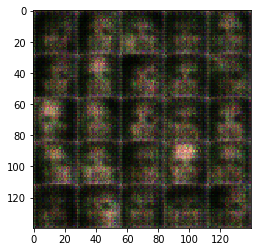

Epoch: 1/1  Steps:  210  Images viewed: 13,440 Discriminator Loss: 0.4601  Generator Loss: 3.1962
Epoch: 1/1  Steps:  220  Images viewed: 14,080 Discriminator Loss: 0.4798  Generator Loss: 2.8078
Epoch: 1/1  Steps:  230  Images viewed: 14,720 Discriminator Loss: 0.4785  Generator Loss: 3.6128
Epoch: 1/1  Steps:  240  Images viewed: 15,360 Discriminator Loss: 0.4573  Generator Loss: 3.1793
Epoch: 1/1  Steps:  250  Images viewed: 16,000 Discriminator Loss: 0.5418  Generator Loss: 4.7572
Epoch: 1/1  Steps:  260  Images viewed: 16,640 Discriminator Loss: 0.4683  Generator Loss: 3.2085
Epoch: 1/1  Steps:  270  Images viewed: 17,280 Discriminator Loss: 0.4722  Generator Loss: 2.9452
Epoch: 1/1  Steps:  280  Images viewed: 17,920 Discriminator Loss: 0.4686  Generator Loss: 3.0024
Epoch: 1/1  Steps:  290  Images viewed: 18,560 Discriminator Loss: 0.4661  Generator Loss: 3.2135
Epoch: 1/1  Steps:  300  Images viewed: 19,200 Discriminator Loss: 0.4720  Generator Loss: 3.5414


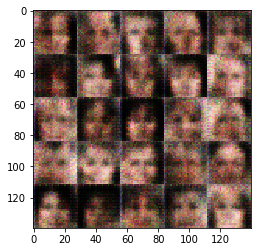

Epoch: 1/1  Steps:  310  Images viewed: 19,840 Discriminator Loss: 0.5488  Generator Loss: 2.3457
Epoch: 1/1  Steps:  320  Images viewed: 20,480 Discriminator Loss: 0.4760  Generator Loss: 3.3438
Epoch: 1/1  Steps:  330  Images viewed: 21,120 Discriminator Loss: 0.4693  Generator Loss: 3.2750
Epoch: 1/1  Steps:  340  Images viewed: 21,760 Discriminator Loss: 0.4660  Generator Loss: 2.9678
Epoch: 1/1  Steps:  350  Images viewed: 22,400 Discriminator Loss: 0.4732  Generator Loss: 3.1092
Epoch: 1/1  Steps:  360  Images viewed: 23,040 Discriminator Loss: 0.4795  Generator Loss: 2.9990
Epoch: 1/1  Steps:  370  Images viewed: 23,680 Discriminator Loss: 0.4737  Generator Loss: 3.1771
Epoch: 1/1  Steps:  380  Images viewed: 24,320 Discriminator Loss: 0.4811  Generator Loss: 3.2529
Epoch: 1/1  Steps:  390  Images viewed: 24,960 Discriminator Loss: 0.4661  Generator Loss: 3.2879
Epoch: 1/1  Steps:  400  Images viewed: 25,600 Discriminator Loss: 0.4885  Generator Loss: 2.8531


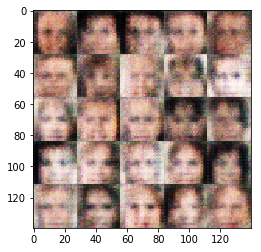

Epoch: 1/1  Steps:  410  Images viewed: 26,240 Discriminator Loss: 0.4755  Generator Loss: 2.8600
Epoch: 1/1  Steps:  420  Images viewed: 26,880 Discriminator Loss: 0.4673  Generator Loss: 3.0752
Epoch: 1/1  Steps:  430  Images viewed: 27,520 Discriminator Loss: 0.4751  Generator Loss: 3.2186
Epoch: 1/1  Steps:  440  Images viewed: 28,160 Discriminator Loss: 0.4956  Generator Loss: 3.0674
Epoch: 1/1  Steps:  450  Images viewed: 28,800 Discriminator Loss: 0.4846  Generator Loss: 2.7759
Epoch: 1/1  Steps:  460  Images viewed: 29,440 Discriminator Loss: 0.4840  Generator Loss: 3.0913
Epoch: 1/1  Steps:  470  Images viewed: 30,080 Discriminator Loss: 0.4813  Generator Loss: 2.8038
Epoch: 1/1  Steps:  480  Images viewed: 30,720 Discriminator Loss: 0.4740  Generator Loss: 2.8874
Epoch: 1/1  Steps:  490  Images viewed: 31,360 Discriminator Loss: 0.4681  Generator Loss: 3.1672
Epoch: 1/1  Steps:  500  Images viewed: 32,000 Discriminator Loss: 0.4743  Generator Loss: 2.8848


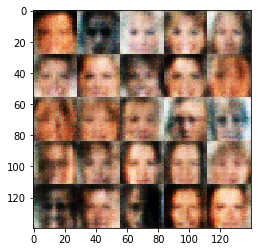

Epoch: 1/1  Steps:  510  Images viewed: 32,640 Discriminator Loss: 0.4948  Generator Loss: 3.7532
Epoch: 1/1  Steps:  520  Images viewed: 33,280 Discriminator Loss: 0.4817  Generator Loss: 3.0815
Epoch: 1/1  Steps:  530  Images viewed: 33,920 Discriminator Loss: 0.4719  Generator Loss: 3.3372
Epoch: 1/1  Steps:  540  Images viewed: 34,560 Discriminator Loss: 0.4883  Generator Loss: 3.0269
Epoch: 1/1  Steps:  550  Images viewed: 35,200 Discriminator Loss: 0.4767  Generator Loss: 2.8229
Epoch: 1/1  Steps:  560  Images viewed: 35,840 Discriminator Loss: 0.4793  Generator Loss: 2.8157
Epoch: 1/1  Steps:  570  Images viewed: 36,480 Discriminator Loss: 0.5081  Generator Loss: 3.8153
Epoch: 1/1  Steps:  580  Images viewed: 37,120 Discriminator Loss: 0.4768  Generator Loss: 2.8849
Epoch: 1/1  Steps:  590  Images viewed: 37,760 Discriminator Loss: 0.4796  Generator Loss: 2.8475
Epoch: 1/1  Steps:  600  Images viewed: 38,400 Discriminator Loss: 0.4873  Generator Loss: 3.4395


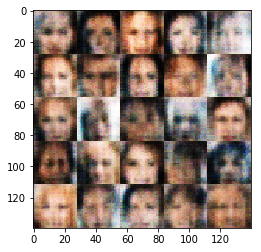

Epoch: 1/1  Steps:  610  Images viewed: 39,040 Discriminator Loss: 0.4754  Generator Loss: 3.1750
Epoch: 1/1  Steps:  620  Images viewed: 39,680 Discriminator Loss: 0.4690  Generator Loss: 3.2095
Epoch: 1/1  Steps:  630  Images viewed: 40,320 Discriminator Loss: 0.4691  Generator Loss: 2.9981
Epoch: 1/1  Steps:  640  Images viewed: 40,960 Discriminator Loss: 0.4756  Generator Loss: 2.8333
Epoch: 1/1  Steps:  650  Images viewed: 41,600 Discriminator Loss: 0.4666  Generator Loss: 2.9455
Epoch: 1/1  Steps:  660  Images viewed: 42,240 Discriminator Loss: 0.4820  Generator Loss: 2.7602
Epoch: 1/1  Steps:  670  Images viewed: 42,880 Discriminator Loss: 0.4948  Generator Loss: 3.5619
Epoch: 1/1  Steps:  680  Images viewed: 43,520 Discriminator Loss: 0.4781  Generator Loss: 2.9622
Epoch: 1/1  Steps:  690  Images viewed: 44,160 Discriminator Loss: 0.5996  Generator Loss: 1.9408
Epoch: 1/1  Steps:  700  Images viewed: 44,800 Discriminator Loss: 0.4934  Generator Loss: 3.2297


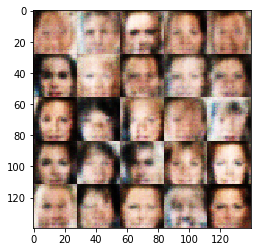

Epoch: 1/1  Steps:  710  Images viewed: 45,440 Discriminator Loss: 0.4825  Generator Loss: 2.8774
Epoch: 1/1  Steps:  720  Images viewed: 46,080 Discriminator Loss: 0.4840  Generator Loss: 2.8790
Epoch: 1/1  Steps:  730  Images viewed: 46,720 Discriminator Loss: 0.4754  Generator Loss: 2.9255
Epoch: 1/1  Steps:  740  Images viewed: 47,360 Discriminator Loss: 0.4792  Generator Loss: 2.9415
Epoch: 1/1  Steps:  750  Images viewed: 48,000 Discriminator Loss: 0.4664  Generator Loss: 3.1753
Epoch: 1/1  Steps:  760  Images viewed: 48,640 Discriminator Loss: 0.4809  Generator Loss: 2.9469
Epoch: 1/1  Steps:  770  Images viewed: 49,280 Discriminator Loss: 0.4678  Generator Loss: 3.1031
Epoch: 1/1  Steps:  780  Images viewed: 49,920 Discriminator Loss: 0.4697  Generator Loss: 3.0383
Epoch: 1/1  Steps:  790  Images viewed: 50,560 Discriminator Loss: 0.4728  Generator Loss: 2.9410
Epoch: 1/1  Steps:  800  Images viewed: 51,200 Discriminator Loss: 0.4735  Generator Loss: 3.1217


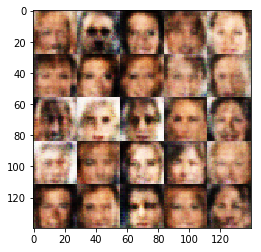

Epoch: 1/1  Steps:  810  Images viewed: 51,840 Discriminator Loss: 0.4742  Generator Loss: 3.0333
Epoch: 1/1  Steps:  820  Images viewed: 52,480 Discriminator Loss: 0.4773  Generator Loss: 3.0823
Epoch: 1/1  Steps:  830  Images viewed: 53,120 Discriminator Loss: 0.4827  Generator Loss: 3.6715
Epoch: 1/1  Steps:  840  Images viewed: 53,760 Discriminator Loss: 0.4950  Generator Loss: 2.6945
Epoch: 1/1  Steps:  850  Images viewed: 54,400 Discriminator Loss: 0.4746  Generator Loss: 2.9706
Epoch: 1/1  Steps:  860  Images viewed: 55,040 Discriminator Loss: 0.4878  Generator Loss: 3.2848
Epoch: 1/1  Steps:  870  Images viewed: 55,680 Discriminator Loss: 0.4990  Generator Loss: 2.5887
Epoch: 1/1  Steps:  880  Images viewed: 56,320 Discriminator Loss: 0.5022  Generator Loss: 3.0052
Epoch: 1/1  Steps:  890  Images viewed: 56,960 Discriminator Loss: 0.4891  Generator Loss: 2.6787
Epoch: 1/1  Steps:  900  Images viewed: 57,600 Discriminator Loss: 0.5014  Generator Loss: 2.5017


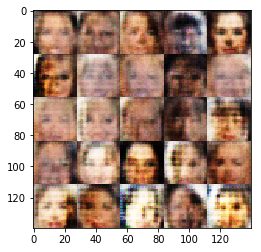

Epoch: 1/1  Steps:  910  Images viewed: 58,240 Discriminator Loss: 0.5066  Generator Loss: 2.4995
Epoch: 1/1  Steps:  920  Images viewed: 58,880 Discriminator Loss: 0.4795  Generator Loss: 2.8476
Epoch: 1/1  Steps:  930  Images viewed: 59,520 Discriminator Loss: 0.5000  Generator Loss: 2.4801
Epoch: 1/1  Steps:  940  Images viewed: 60,160 Discriminator Loss: 0.4922  Generator Loss: 2.8721
Epoch: 1/1  Steps:  950  Images viewed: 60,800 Discriminator Loss: 0.4709  Generator Loss: 3.0338
Epoch: 1/1  Steps:  960  Images viewed: 61,440 Discriminator Loss: 0.4903  Generator Loss: 2.7753
Epoch: 1/1  Steps:  970  Images viewed: 62,080 Discriminator Loss: 0.5024  Generator Loss: 2.5498
Epoch: 1/1  Steps:  980  Images viewed: 62,720 Discriminator Loss: 0.4917  Generator Loss: 2.5889
Epoch: 1/1  Steps:  990  Images viewed: 63,360 Discriminator Loss: 0.4953  Generator Loss: 2.6982
Epoch: 1/1  Steps: 1,000  Images viewed: 64,000 Discriminator Loss: 0.4969  Generator Loss: 2.7363


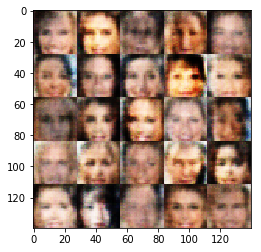

Epoch: 1/1  Steps: 1,010  Images viewed: 64,640 Discriminator Loss: 0.4948  Generator Loss: 3.0486
Epoch: 1/1  Steps: 1,020  Images viewed: 65,280 Discriminator Loss: 0.4846  Generator Loss: 2.9324
Epoch: 1/1  Steps: 1,030  Images viewed: 65,920 Discriminator Loss: 0.4903  Generator Loss: 2.7524
Epoch: 1/1  Steps: 1,040  Images viewed: 66,560 Discriminator Loss: 0.5012  Generator Loss: 2.5291
Epoch: 1/1  Steps: 1,050  Images viewed: 67,200 Discriminator Loss: 0.5009  Generator Loss: 2.5664
Epoch: 1/1  Steps: 1,060  Images viewed: 67,840 Discriminator Loss: 0.5009  Generator Loss: 2.5658
Epoch: 1/1  Steps: 1,070  Images viewed: 68,480 Discriminator Loss: 0.4849  Generator Loss: 2.8919
Epoch: 1/1  Steps: 1,080  Images viewed: 69,120 Discriminator Loss: 0.4948  Generator Loss: 2.7315
Epoch: 1/1  Steps: 1,090  Images viewed: 69,760 Discriminator Loss: 0.4937  Generator Loss: 2.6477
Epoch: 1/1  Steps: 1,100  Images viewed: 70,400 Discriminator Loss: 0.4894  Generator Loss: 2.9594


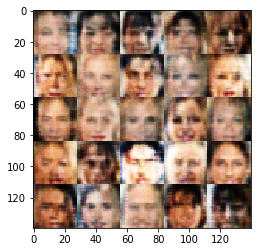

Epoch: 1/1  Steps: 1,110  Images viewed: 71,040 Discriminator Loss: 0.4976  Generator Loss: 2.6313
Epoch: 1/1  Steps: 1,120  Images viewed: 71,680 Discriminator Loss: 0.4878  Generator Loss: 3.0967
Epoch: 1/1  Steps: 1,130  Images viewed: 72,320 Discriminator Loss: 0.4917  Generator Loss: 2.9123
Epoch: 1/1  Steps: 1,140  Images viewed: 72,960 Discriminator Loss: 0.4998  Generator Loss: 3.2418
Epoch: 1/1  Steps: 1,150  Images viewed: 73,600 Discriminator Loss: 0.4940  Generator Loss: 2.6548
Epoch: 1/1  Steps: 1,160  Images viewed: 74,240 Discriminator Loss: 0.4907  Generator Loss: 2.7738
Epoch: 1/1  Steps: 1,170  Images viewed: 74,880 Discriminator Loss: 0.4954  Generator Loss: 2.7202
Epoch: 1/1  Steps: 1,180  Images viewed: 75,520 Discriminator Loss: 0.4906  Generator Loss: 2.6625
Epoch: 1/1  Steps: 1,190  Images viewed: 76,160 Discriminator Loss: 0.4881  Generator Loss: 2.9464
Epoch: 1/1  Steps: 1,200  Images viewed: 76,800 Discriminator Loss: 0.5029  Generator Loss: 2.8163


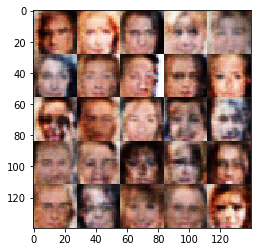

Epoch: 1/1  Steps: 1,210  Images viewed: 77,440 Discriminator Loss: 0.4894  Generator Loss: 2.7255
Epoch: 1/1  Steps: 1,220  Images viewed: 78,080 Discriminator Loss: 0.5190  Generator Loss: 3.3739
Epoch: 1/1  Steps: 1,230  Images viewed: 78,720 Discriminator Loss: 0.4995  Generator Loss: 2.9547
Epoch: 1/1  Steps: 1,240  Images viewed: 79,360 Discriminator Loss: 0.4870  Generator Loss: 2.6944
Epoch: 1/1  Steps: 1,250  Images viewed: 80,000 Discriminator Loss: 0.4920  Generator Loss: 2.7867
Epoch: 1/1  Steps: 1,260  Images viewed: 80,640 Discriminator Loss: 0.4833  Generator Loss: 2.8092
Epoch: 1/1  Steps: 1,270  Images viewed: 81,280 Discriminator Loss: 0.4972  Generator Loss: 2.6320
Epoch: 1/1  Steps: 1,280  Images viewed: 81,920 Discriminator Loss: 0.4871  Generator Loss: 2.9263
Epoch: 1/1  Steps: 1,290  Images viewed: 82,560 Discriminator Loss: 0.4860  Generator Loss: 2.8879
Epoch: 1/1  Steps: 1,300  Images viewed: 83,200 Discriminator Loss: 0.4886  Generator Loss: 2.6981


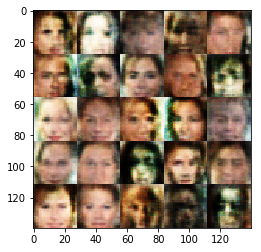

Epoch: 1/1  Steps: 1,310  Images viewed: 83,840 Discriminator Loss: 0.4920  Generator Loss: 2.7465
Epoch: 1/1  Steps: 1,320  Images viewed: 84,480 Discriminator Loss: 0.4985  Generator Loss: 2.5965
Epoch: 1/1  Steps: 1,330  Images viewed: 85,120 Discriminator Loss: 0.4888  Generator Loss: 2.7473
Epoch: 1/1  Steps: 1,340  Images viewed: 85,760 Discriminator Loss: 0.4927  Generator Loss: 2.8087
Epoch: 1/1  Steps: 1,350  Images viewed: 86,400 Discriminator Loss: 0.4848  Generator Loss: 3.2990
Epoch: 1/1  Steps: 1,360  Images viewed: 87,040 Discriminator Loss: 0.4988  Generator Loss: 3.3370
Epoch: 1/1  Steps: 1,370  Images viewed: 87,680 Discriminator Loss: 0.4840  Generator Loss: 2.7465
Epoch: 1/1  Steps: 1,380  Images viewed: 88,320 Discriminator Loss: 0.4831  Generator Loss: 2.9077
Epoch: 1/1  Steps: 1,390  Images viewed: 88,960 Discriminator Loss: 0.4914  Generator Loss: 2.7115
Epoch: 1/1  Steps: 1,400  Images viewed: 89,600 Discriminator Loss: 0.4965  Generator Loss: 2.9584


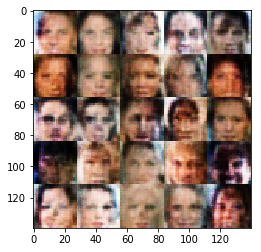

Epoch: 1/1  Steps: 1,410  Images viewed: 90,240 Discriminator Loss: 0.4845  Generator Loss: 2.8781
Epoch: 1/1  Steps: 1,420  Images viewed: 90,880 Discriminator Loss: 0.5060  Generator Loss: 2.4875
Epoch: 1/1  Steps: 1,430  Images viewed: 91,520 Discriminator Loss: 0.4894  Generator Loss: 2.8022
Epoch: 1/1  Steps: 1,440  Images viewed: 92,160 Discriminator Loss: 0.4985  Generator Loss: 2.6023
Epoch: 1/1  Steps: 1,450  Images viewed: 92,800 Discriminator Loss: 0.4940  Generator Loss: 2.6557
Epoch: 1/1  Steps: 1,460  Images viewed: 93,440 Discriminator Loss: 0.4798  Generator Loss: 2.8612
Epoch: 1/1  Steps: 1,470  Images viewed: 94,080 Discriminator Loss: 0.4923  Generator Loss: 2.5918
Epoch: 1/1  Steps: 1,480  Images viewed: 94,720 Discriminator Loss: 0.4835  Generator Loss: 3.1162
Epoch: 1/1  Steps: 1,490  Images viewed: 95,360 Discriminator Loss: 0.4915  Generator Loss: 2.8077
Epoch: 1/1  Steps: 1,500  Images viewed: 96,000 Discriminator Loss: 0.5083  Generator Loss: 2.5663


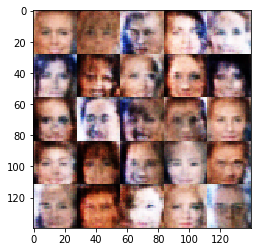

Epoch: 1/1  Steps: 1,510  Images viewed: 96,640 Discriminator Loss: 0.4907  Generator Loss: 2.8473
Epoch: 1/1  Steps: 1,520  Images viewed: 97,280 Discriminator Loss: 0.4953  Generator Loss: 2.6775
Epoch: 1/1  Steps: 1,530  Images viewed: 97,920 Discriminator Loss: 0.4938  Generator Loss: 2.6870
Epoch: 1/1  Steps: 1,540  Images viewed: 98,560 Discriminator Loss: 0.4952  Generator Loss: 2.9522
Epoch: 1/1  Steps: 1,550  Images viewed: 99,200 Discriminator Loss: 0.4938  Generator Loss: 2.6851
Epoch: 1/1  Steps: 1,560  Images viewed: 99,840 Discriminator Loss: 0.4873  Generator Loss: 2.7958
Epoch: 1/1  Steps: 1,570  Images viewed: 100,480 Discriminator Loss: 0.4963  Generator Loss: 2.6434
Epoch: 1/1  Steps: 1,580  Images viewed: 101,120 Discriminator Loss: 0.4925  Generator Loss: 2.8323
Epoch: 1/1  Steps: 1,590  Images viewed: 101,760 Discriminator Loss: 0.4863  Generator Loss: 2.9208
Epoch: 1/1  Steps: 1,600  Images viewed: 102,400 Discriminator Loss: 0.4927  Generator Loss: 3.1234


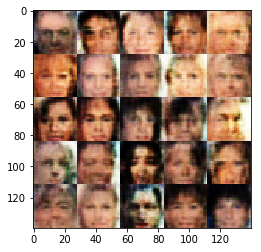

Epoch: 1/1  Steps: 1,610  Images viewed: 103,040 Discriminator Loss: 0.4950  Generator Loss: 2.6933
Epoch: 1/1  Steps: 1,620  Images viewed: 103,680 Discriminator Loss: 0.4884  Generator Loss: 2.8071
Epoch: 1/1  Steps: 1,630  Images viewed: 104,320 Discriminator Loss: 0.4750  Generator Loss: 3.0761
Epoch: 1/1  Steps: 1,640  Images viewed: 104,960 Discriminator Loss: 0.4923  Generator Loss: 2.8311
Epoch: 1/1  Steps: 1,650  Images viewed: 105,600 Discriminator Loss: 0.4842  Generator Loss: 2.8523
Epoch: 1/1  Steps: 1,660  Images viewed: 106,240 Discriminator Loss: 0.4921  Generator Loss: 2.9480
Epoch: 1/1  Steps: 1,670  Images viewed: 106,880 Discriminator Loss: 0.4753  Generator Loss: 3.0588
Epoch: 1/1  Steps: 1,680  Images viewed: 107,520 Discriminator Loss: 0.4912  Generator Loss: 2.5576
Epoch: 1/1  Steps: 1,690  Images viewed: 108,160 Discriminator Loss: 0.4823  Generator Loss: 3.3068
Epoch: 1/1  Steps: 1,700  Images viewed: 108,800 Discriminator Loss: 0.4912  Generator Loss: 2.8220


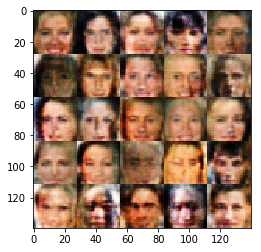

Epoch: 1/1  Steps: 1,710  Images viewed: 109,440 Discriminator Loss: 0.4871  Generator Loss: 2.8129
Epoch: 1/1  Steps: 1,720  Images viewed: 110,080 Discriminator Loss: 0.4843  Generator Loss: 2.9456
Epoch: 1/1  Steps: 1,730  Images viewed: 110,720 Discriminator Loss: 0.4997  Generator Loss: 2.5374
Epoch: 1/1  Steps: 1,740  Images viewed: 111,360 Discriminator Loss: 0.4813  Generator Loss: 2.8765
Epoch: 1/1  Steps: 1,750  Images viewed: 112,000 Discriminator Loss: 0.4933  Generator Loss: 2.8075
Epoch: 1/1  Steps: 1,760  Images viewed: 112,640 Discriminator Loss: 0.4876  Generator Loss: 2.7962
Epoch: 1/1  Steps: 1,770  Images viewed: 113,280 Discriminator Loss: 0.4996  Generator Loss: 2.5077
Epoch: 1/1  Steps: 1,780  Images viewed: 113,920 Discriminator Loss: 0.5045  Generator Loss: 2.5137
Epoch: 1/1  Steps: 1,790  Images viewed: 114,560 Discriminator Loss: 0.4940  Generator Loss: 2.9041
Epoch: 1/1  Steps: 1,800  Images viewed: 115,200 Discriminator Loss: 0.4868  Generator Loss: 2.9243


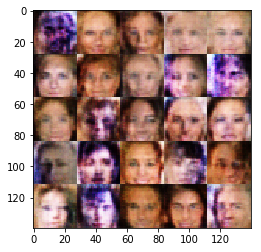

Epoch: 1/1  Steps: 1,810  Images viewed: 115,840 Discriminator Loss: 0.4853  Generator Loss: 2.8957
Epoch: 1/1  Steps: 1,820  Images viewed: 116,480 Discriminator Loss: 0.4864  Generator Loss: 2.8843
Epoch: 1/1  Steps: 1,830  Images viewed: 117,120 Discriminator Loss: 0.4916  Generator Loss: 2.7461
Epoch: 1/1  Steps: 1,840  Images viewed: 117,760 Discriminator Loss: 0.4890  Generator Loss: 2.7356
Epoch: 1/1  Steps: 1,850  Images viewed: 118,400 Discriminator Loss: 0.4860  Generator Loss: 2.8236
Epoch: 1/1  Steps: 1,860  Images viewed: 119,040 Discriminator Loss: 0.4908  Generator Loss: 2.8553
Epoch: 1/1  Steps: 1,870  Images viewed: 119,680 Discriminator Loss: 0.4857  Generator Loss: 2.8390
Epoch: 1/1  Steps: 1,880  Images viewed: 120,320 Discriminator Loss: 0.4882  Generator Loss: 3.0366
Epoch: 1/1  Steps: 1,890  Images viewed: 120,960 Discriminator Loss: 0.4909  Generator Loss: 2.7201
Epoch: 1/1  Steps: 1,900  Images viewed: 121,600 Discriminator Loss: 0.4959  Generator Loss: 2.5644


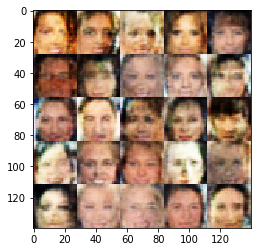

Epoch: 1/1  Steps: 1,910  Images viewed: 122,240 Discriminator Loss: 0.4941  Generator Loss: 2.7349
Epoch: 1/1  Steps: 1,920  Images viewed: 122,880 Discriminator Loss: 0.4887  Generator Loss: 2.6989
Epoch: 1/1  Steps: 1,930  Images viewed: 123,520 Discriminator Loss: 0.4809  Generator Loss: 3.0258
Epoch: 1/1  Steps: 1,940  Images viewed: 124,160 Discriminator Loss: 0.4860  Generator Loss: 2.9537
Epoch: 1/1  Steps: 1,950  Images viewed: 124,800 Discriminator Loss: 0.4897  Generator Loss: 2.7892
Epoch: 1/1  Steps: 1,960  Images viewed: 125,440 Discriminator Loss: 0.4869  Generator Loss: 3.0022
Epoch: 1/1  Steps: 1,970  Images viewed: 126,080 Discriminator Loss: 0.4865  Generator Loss: 2.8129
Epoch: 1/1  Steps: 1,980  Images viewed: 126,720 Discriminator Loss: 0.4873  Generator Loss: 2.8464
Epoch: 1/1  Steps: 1,990  Images viewed: 127,360 Discriminator Loss: 0.5093  Generator Loss: 2.4331
Epoch: 1/1  Steps: 2,000  Images viewed: 128,000 Discriminator Loss: 0.4816  Generator Loss: 3.0487


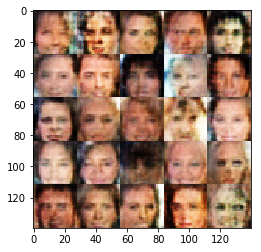

Epoch: 1/1  Steps: 2,010  Images viewed: 128,640 Discriminator Loss: 0.4940  Generator Loss: 2.6578
Epoch: 1/1  Steps: 2,020  Images viewed: 129,280 Discriminator Loss: 0.4892  Generator Loss: 2.7774
Epoch: 1/1  Steps: 2,030  Images viewed: 129,920 Discriminator Loss: 0.4817  Generator Loss: 2.9059
Epoch: 1/1  Steps: 2,040  Images viewed: 130,560 Discriminator Loss: 0.4849  Generator Loss: 2.9013
Epoch: 1/1  Steps: 2,050  Images viewed: 131,200 Discriminator Loss: 0.4903  Generator Loss: 2.8109
Epoch: 1/1  Steps: 2,060  Images viewed: 131,840 Discriminator Loss: 0.4914  Generator Loss: 2.7101
Epoch: 1/1  Steps: 2,070  Images viewed: 132,480 Discriminator Loss: 0.4860  Generator Loss: 2.8681
Epoch: 1/1  Steps: 2,080  Images viewed: 133,120 Discriminator Loss: 0.4834  Generator Loss: 2.7228
Epoch: 1/1  Steps: 2,090  Images viewed: 133,760 Discriminator Loss: 0.4885  Generator Loss: 2.8213
Epoch: 1/1  Steps: 2,100  Images viewed: 134,400 Discriminator Loss: 0.4917  Generator Loss: 2.6941


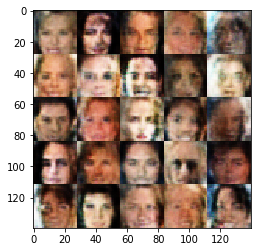

Epoch: 1/1  Steps: 2,110  Images viewed: 135,040 Discriminator Loss: 0.4801  Generator Loss: 2.9949
Epoch: 1/1  Steps: 2,120  Images viewed: 135,680 Discriminator Loss: 0.4934  Generator Loss: 2.9479
Epoch: 1/1  Steps: 2,130  Images viewed: 136,320 Discriminator Loss: 0.4862  Generator Loss: 2.7526
Epoch: 1/1  Steps: 2,140  Images viewed: 136,960 Discriminator Loss: 0.4838  Generator Loss: 2.8424
Epoch: 1/1  Steps: 2,150  Images viewed: 137,600 Discriminator Loss: 0.4876  Generator Loss: 3.0798
Epoch: 1/1  Steps: 2,160  Images viewed: 138,240 Discriminator Loss: 0.5018  Generator Loss: 2.6805
Epoch: 1/1  Steps: 2,170  Images viewed: 138,880 Discriminator Loss: 0.4902  Generator Loss: 2.8703
Epoch: 1/1  Steps: 2,180  Images viewed: 139,520 Discriminator Loss: 0.4880  Generator Loss: 2.7246
Epoch: 1/1  Steps: 2,190  Images viewed: 140,160 Discriminator Loss: 0.4909  Generator Loss: 2.6783
Epoch: 1/1  Steps: 2,200  Images viewed: 140,800 Discriminator Loss: 0.4905  Generator Loss: 2.6953


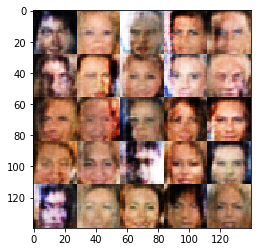

Epoch: 1/1  Steps: 2,210  Images viewed: 141,440 Discriminator Loss: 0.4861  Generator Loss: 2.7900
Epoch: 1/1  Steps: 2,220  Images viewed: 142,080 Discriminator Loss: 0.4892  Generator Loss: 2.7515
Epoch: 1/1  Steps: 2,230  Images viewed: 142,720 Discriminator Loss: 0.4864  Generator Loss: 2.9499
Epoch: 1/1  Steps: 2,240  Images viewed: 143,360 Discriminator Loss: 0.4875  Generator Loss: 2.9519
Epoch: 1/1  Steps: 2,250  Images viewed: 144,000 Discriminator Loss: 0.4967  Generator Loss: 2.6990
Epoch: 1/1  Steps: 2,260  Images viewed: 144,640 Discriminator Loss: 0.4878  Generator Loss: 2.9457
Epoch: 1/1  Steps: 2,270  Images viewed: 145,280 Discriminator Loss: 0.5038  Generator Loss: 3.0701
Epoch: 1/1  Steps: 2,280  Images viewed: 145,920 Discriminator Loss: 0.4803  Generator Loss: 2.7940
Epoch: 1/1  Steps: 2,290  Images viewed: 146,560 Discriminator Loss: 0.4976  Generator Loss: 2.5852
Epoch: 1/1  Steps: 2,300  Images viewed: 147,200 Discriminator Loss: 0.4841  Generator Loss: 2.8072


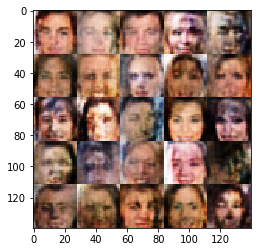

Epoch: 1/1  Steps: 2,310  Images viewed: 147,840 Discriminator Loss: 0.4829  Generator Loss: 2.6847
Epoch: 1/1  Steps: 2,320  Images viewed: 148,480 Discriminator Loss: 0.4900  Generator Loss: 2.7609
Epoch: 1/1  Steps: 2,330  Images viewed: 149,120 Discriminator Loss: 0.4878  Generator Loss: 2.8709
Epoch: 1/1  Steps: 2,340  Images viewed: 149,760 Discriminator Loss: 0.4871  Generator Loss: 2.8109
Epoch: 1/1  Steps: 2,350  Images viewed: 150,400 Discriminator Loss: 0.4820  Generator Loss: 2.9965
Epoch: 1/1  Steps: 2,360  Images viewed: 151,040 Discriminator Loss: 0.4889  Generator Loss: 2.8737
Epoch: 1/1  Steps: 2,370  Images viewed: 151,680 Discriminator Loss: 0.4861  Generator Loss: 2.9276
Epoch: 1/1  Steps: 2,380  Images viewed: 152,320 Discriminator Loss: 0.4905  Generator Loss: 3.0303
Epoch: 1/1  Steps: 2,390  Images viewed: 152,960 Discriminator Loss: 0.4926  Generator Loss: 2.8864
Epoch: 1/1  Steps: 2,400  Images viewed: 153,600 Discriminator Loss: 0.4854  Generator Loss: 2.9563


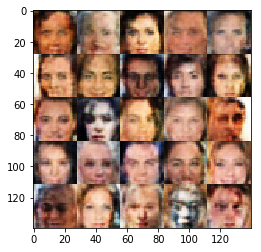

Epoch: 1/1  Steps: 2,410  Images viewed: 154,240 Discriminator Loss: 0.4844  Generator Loss: 2.8646
Epoch: 1/1  Steps: 2,420  Images viewed: 154,880 Discriminator Loss: 0.4861  Generator Loss: 2.8695
Epoch: 1/1  Steps: 2,430  Images viewed: 155,520 Discriminator Loss: 0.4906  Generator Loss: 2.9797
Epoch: 1/1  Steps: 2,440  Images viewed: 156,160 Discriminator Loss: 0.4951  Generator Loss: 2.8671
Epoch: 1/1  Steps: 2,450  Images viewed: 156,800 Discriminator Loss: 0.4771  Generator Loss: 2.8996
Epoch: 1/1  Steps: 2,460  Images viewed: 157,440 Discriminator Loss: 0.4933  Generator Loss: 2.6100
Epoch: 1/1  Steps: 2,470  Images viewed: 158,080 Discriminator Loss: 0.4863  Generator Loss: 3.2106
Epoch: 1/1  Steps: 2,480  Images viewed: 158,720 Discriminator Loss: 0.4894  Generator Loss: 2.8056
Epoch: 1/1  Steps: 2,490  Images viewed: 159,360 Discriminator Loss: 0.4802  Generator Loss: 2.8497
Epoch: 1/1  Steps: 2,500  Images viewed: 160,000 Discriminator Loss: 0.4842  Generator Loss: 2.8484


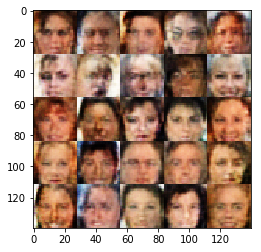

Epoch: 1/1  Steps: 2,510  Images viewed: 160,640 Discriminator Loss: 0.4956  Generator Loss: 2.8956
Epoch: 1/1  Steps: 2,520  Images viewed: 161,280 Discriminator Loss: 0.4865  Generator Loss: 2.8992
Epoch: 1/1  Steps: 2,530  Images viewed: 161,920 Discriminator Loss: 0.4805  Generator Loss: 2.8357
Epoch: 1/1  Steps: 2,540  Images viewed: 162,560 Discriminator Loss: 0.4905  Generator Loss: 2.6834
Epoch: 1/1  Steps: 2,550  Images viewed: 163,200 Discriminator Loss: 0.4891  Generator Loss: 3.0842
Epoch: 1/1  Steps: 2,560  Images viewed: 163,840 Discriminator Loss: 0.4823  Generator Loss: 2.8961
Epoch: 1/1  Steps: 2,570  Images viewed: 164,480 Discriminator Loss: 0.4823  Generator Loss: 2.8394
Epoch: 1/1  Steps: 2,580  Images viewed: 165,120 Discriminator Loss: 0.4865  Generator Loss: 2.6723
Epoch: 1/1  Steps: 2,590  Images viewed: 165,760 Discriminator Loss: 0.4914  Generator Loss: 2.6620
Epoch: 1/1  Steps: 2,600  Images viewed: 166,400 Discriminator Loss: 0.4774  Generator Loss: 3.0647


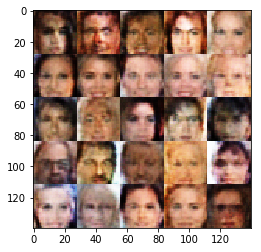

Epoch: 1/1  Steps: 2,610  Images viewed: 167,040 Discriminator Loss: 0.4879  Generator Loss: 2.7074
Epoch: 1/1  Steps: 2,620  Images viewed: 167,680 Discriminator Loss: 0.4901  Generator Loss: 2.7952
Epoch: 1/1  Steps: 2,630  Images viewed: 168,320 Discriminator Loss: 0.4874  Generator Loss: 3.0353
Epoch: 1/1  Steps: 2,640  Images viewed: 168,960 Discriminator Loss: 0.4897  Generator Loss: 2.6977
Epoch: 1/1  Steps: 2,650  Images viewed: 169,600 Discriminator Loss: 0.4985  Generator Loss: 2.6546
Epoch: 1/1  Steps: 2,660  Images viewed: 170,240 Discriminator Loss: 0.4901  Generator Loss: 2.7471
Epoch: 1/1  Steps: 2,670  Images viewed: 170,880 Discriminator Loss: 0.4914  Generator Loss: 2.7047
Epoch: 1/1  Steps: 2,680  Images viewed: 171,520 Discriminator Loss: 0.4821  Generator Loss: 2.8596
Epoch: 1/1  Steps: 2,690  Images viewed: 172,160 Discriminator Loss: 0.4856  Generator Loss: 2.7177
Epoch: 1/1  Steps: 2,700  Images viewed: 172,800 Discriminator Loss: 0.4845  Generator Loss: 2.9319


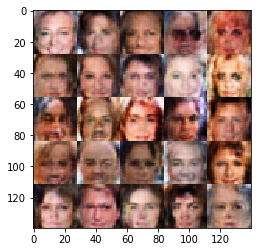

Epoch: 1/1  Steps: 2,710  Images viewed: 173,440 Discriminator Loss: 0.4829  Generator Loss: 2.9480
Epoch: 1/1  Steps: 2,720  Images viewed: 174,080 Discriminator Loss: 0.4915  Generator Loss: 2.7415
Epoch: 1/1  Steps: 2,730  Images viewed: 174,720 Discriminator Loss: 0.4922  Generator Loss: 2.7465
Epoch: 1/1  Steps: 2,740  Images viewed: 175,360 Discriminator Loss: 0.4895  Generator Loss: 2.7298
Epoch: 1/1  Steps: 2,750  Images viewed: 176,000 Discriminator Loss: 0.5078  Generator Loss: 2.4563
Epoch: 1/1  Steps: 2,760  Images viewed: 176,640 Discriminator Loss: 0.4825  Generator Loss: 3.1424
Epoch: 1/1  Steps: 2,770  Images viewed: 177,280 Discriminator Loss: 0.4911  Generator Loss: 2.7510
Epoch: 1/1  Steps: 2,780  Images viewed: 177,920 Discriminator Loss: 0.4857  Generator Loss: 2.8777
Epoch: 1/1  Steps: 2,790  Images viewed: 178,560 Discriminator Loss: 0.4784  Generator Loss: 2.9751
Epoch: 1/1  Steps: 2,800  Images viewed: 179,200 Discriminator Loss: 0.4950  Generator Loss: 2.7197


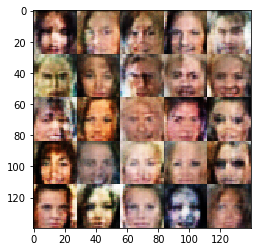

Epoch: 1/1  Steps: 2,810  Images viewed: 179,840 Discriminator Loss: 0.4824  Generator Loss: 2.9251
Epoch: 1/1  Steps: 2,820  Images viewed: 180,480 Discriminator Loss: 0.4940  Generator Loss: 2.6442
Epoch: 1/1  Steps: 2,830  Images viewed: 181,120 Discriminator Loss: 0.4890  Generator Loss: 2.7537
Epoch: 1/1  Steps: 2,840  Images viewed: 181,760 Discriminator Loss: 0.4879  Generator Loss: 3.2256
Epoch: 1/1  Steps: 2,850  Images viewed: 182,400 Discriminator Loss: 0.4935  Generator Loss: 2.9435
Epoch: 1/1  Steps: 2,860  Images viewed: 183,040 Discriminator Loss: 0.4850  Generator Loss: 2.9499
Epoch: 1/1  Steps: 2,870  Images viewed: 183,680 Discriminator Loss: 0.4912  Generator Loss: 2.6510
Epoch: 1/1  Steps: 2,880  Images viewed: 184,320 Discriminator Loss: 0.4821  Generator Loss: 2.9292
Epoch: 1/1  Steps: 2,890  Images viewed: 184,960 Discriminator Loss: 0.4868  Generator Loss: 2.7682
Epoch: 1/1  Steps: 2,900  Images viewed: 185,600 Discriminator Loss: 0.4934  Generator Loss: 2.5865


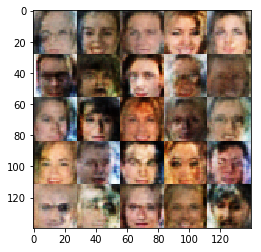

Epoch: 1/1  Steps: 2,910  Images viewed: 186,240 Discriminator Loss: 0.4844  Generator Loss: 2.8189
Epoch: 1/1  Steps: 2,920  Images viewed: 186,880 Discriminator Loss: 0.4960  Generator Loss: 2.5533
Epoch: 1/1  Steps: 2,930  Images viewed: 187,520 Discriminator Loss: 0.4917  Generator Loss: 3.0423
Epoch: 1/1  Steps: 2,940  Images viewed: 188,160 Discriminator Loss: 0.4760  Generator Loss: 2.8808
Epoch: 1/1  Steps: 2,950  Images viewed: 188,800 Discriminator Loss: 0.4880  Generator Loss: 2.7466
Epoch: 1/1  Steps: 2,960  Images viewed: 189,440 Discriminator Loss: 0.4896  Generator Loss: 2.8551
Epoch: 1/1  Steps: 2,970  Images viewed: 190,080 Discriminator Loss: 0.4869  Generator Loss: 2.9107
Epoch: 1/1  Steps: 2,980  Images viewed: 190,720 Discriminator Loss: 0.4934  Generator Loss: 2.8048
Epoch: 1/1  Steps: 2,990  Images viewed: 191,360 Discriminator Loss: 0.4880  Generator Loss: 2.7748
Epoch: 1/1  Steps: 3,000  Images viewed: 192,000 Discriminator Loss: 0.4953  Generator Loss: 2.6034


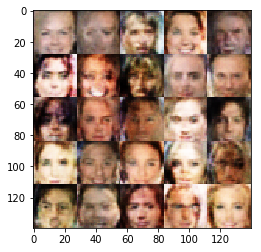

Epoch: 1/1  Steps: 3,010  Images viewed: 192,640 Discriminator Loss: 0.4921  Generator Loss: 2.6216
Epoch: 1/1  Steps: 3,020  Images viewed: 193,280 Discriminator Loss: 0.4849  Generator Loss: 2.8435
Epoch: 1/1  Steps: 3,030  Images viewed: 193,920 Discriminator Loss: 0.4806  Generator Loss: 2.8466
Epoch: 1/1  Steps: 3,040  Images viewed: 194,560 Discriminator Loss: 0.4866  Generator Loss: 2.8148
Epoch: 1/1  Steps: 3,050  Images viewed: 195,200 Discriminator Loss: 0.4864  Generator Loss: 2.8559
Epoch: 1/1  Steps: 3,060  Images viewed: 195,840 Discriminator Loss: 0.4744  Generator Loss: 3.0815
Epoch: 1/1  Steps: 3,070  Images viewed: 196,480 Discriminator Loss: 0.4948  Generator Loss: 2.5779
Epoch: 1/1  Steps: 3,080  Images viewed: 197,120 Discriminator Loss: 0.4840  Generator Loss: 3.0464
Epoch: 1/1  Steps: 3,090  Images viewed: 197,760 Discriminator Loss: 0.4819  Generator Loss: 2.8591
Epoch: 1/1  Steps: 3,100  Images viewed: 198,400 Discriminator Loss: 0.4935  Generator Loss: 2.6580


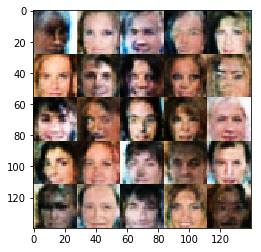

Epoch: 1/1  Steps: 3,110  Images viewed: 199,040 Discriminator Loss: 0.4963  Generator Loss: 2.7465
Epoch: 1/1  Steps: 3,120  Images viewed: 199,680 Discriminator Loss: 0.4772  Generator Loss: 2.8210
Epoch: 1/1  Steps: 3,130  Images viewed: 200,320 Discriminator Loss: 0.4910  Generator Loss: 2.6776
Epoch: 1/1  Steps: 3,140  Images viewed: 200,960 Discriminator Loss: 0.4808  Generator Loss: 2.8737
Epoch: 1/1  Steps: 3,150  Images viewed: 201,600 Discriminator Loss: 0.4931  Generator Loss: 2.6894
Epoch: 1/1  Steps: 3,160  Images viewed: 202,240 Discriminator Loss: 0.4828  Generator Loss: 2.8168


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001  # 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.